In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain.prompts import PromptTemplate
import pymorphy2
from langchain_core.language_models.llms import LLM
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import gc
import sys
import rouge
from langchain_core.output_parsers import BaseGenerationOutputParser
from collections import Counter
import matplotlib.pyplot as plt

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Подготовка данных

In [ ]:
with open("./triviaqa-unfiltered/unfiltered-web-dev.json") as file:
    data = json.load(file)

In [ ]:
data = data['Data']

In [ ]:
len(data)

11313

Сократим размер датасет вследствии ограничений в ресурсах

In [ ]:
data = data[:5000]

In [ ]:
data[0] # Пример данных для QA

{'Answer': {'Aliases': ['David Seville'],
  'MatchedWikiEntityName': 'David Seville',
  'NormalizedAliases': ['david seville'],
  'NormalizedMatchedWikiEntityName': 'david seville',
  'NormalizedValue': 'david seville',
  'Type': 'WikipediaEntity',
  'Value': 'David Seville'},
 'EntityPages': [],
 'Question': 'Who was the man behind The Chipmunks?',
 'QuestionId': 'tc_2',
 'QuestionSource': 'http://www.triviacountry.com/',
 'SearchResults': [{'Description': "Alice Cooper's The Man Behind the Mask Music Video. Chipmunk styled",
   'DisplayUrl': 'www.youtube.com/watch?v=EFme-4S6l3Y',
   'Rank': 0,
   'Title': 'The Man Behind the Mask (Chipmunk Version) - YouTube',
   'Url': 'http://www.youtube.com/watch?v=EFme-4S6l3Y'},
  {'Description': 'Listen to all the actors who have voiced the following Alvin & The Chipmunks characters ... One Punch Man. 3. Steven ... Inyxception Enterprises, Inc. DBA Behind The ...',
   'DisplayUrl': 'www.behindthevoiceactors.com/tv-shows/Alvin-and-The-Chipmunks',

In [ ]:
def _format_context(item):
    return f"""Title: {item['Title']}\nDescription: {item['Description']}"""

def get_qaprompt(item):
    return {
        "question": item['Question'],
        "context": "\n\n".join([_format_context(i) for i in item['SearchResults']])
    }

In [ ]:
get_qaprompt(data[0])

{'question': 'Who was the man behind The Chipmunks?',
 'context': 'Title: The Man Behind the Mask (Chipmunk Version) - YouTube\nDescription: Alice Cooper\'s The Man Behind the Mask Music Video. Chipmunk styled\n\nTitle: Alvin & The Chipmunks - Behind The Voice Actors - Images ...\nDescription: Listen to all the actors who have voiced the following Alvin & The Chipmunks characters ... One Punch Man. 3. Steven ... Inyxception Enterprises, Inc. DBA Behind The ...\n\nTitle: The Easter Chipmunk - Cast Images | Behind The Voice Actors\nDescription: The Easter Chipmunk. US Premiere: Apr 14, 1995. ... One Punch Man. 3. Steven ... All original content © 2009-2016 Inyxception Enterprises, Inc. DBA Behind The Voice ...\n\nTitle: Alvin Seville - Alvin and the Chipmunks Wiki - Wikia\nDescription: Alvin Seville is one of the Chipmunks and the main protagonist ... his role as band front man, ... charging Dave orders them to leave pop stardom behind and ...\n\nTitle: Alvin and the Chipmunks (2007) - I

In [ ]:
df = pd.read_csv("./wikihowAll.csv")
df.shape

(215365, 3)

In [ ]:
df = df.dropna(how='any')
df.shape

(214294, 3)

Так же как и с QA сократим размер датасета вследствие ограничения вычислительных ресурсов

In [ ]:
df = df.iloc[:5000]

In [ ]:
df.head()

,headline,title,text
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...
4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


In [ ]:
def get_sumprompt(item):
    return {"text": item['text']}

In [ ]:
gc.collect()

0

In [ ]:
data[0]['Answer']['Value']

'David Seville'

In [ ]:
df['headline']

0     \nKeep related supplies in the same area.,\nMa...
1     \nCreate a sketch in the NeoPopRealist manner ...
2     \nGet a bachelor’s degree.,\nEnroll in a studi...
3     \nStart with some experience or interest in ar...
4     \nKeep your reference materials, sketches, art...
                            ...                        
95    \nWatch out for a shifting saddle.,\nNotice if...
96    \nBuild a trustworthy bond with your piggy.,\n...
97    \nLet your guinea pig out of its cage.,\nMake ...
98    \nCondition your guinea pig to the clicker or ...
99    \nPlace your guinea pig in a piggy-proof area ...
Name: headline, Length: 100, dtype: object

In [ ]:
data

[{'Answer': {'Aliases': ['David Seville'],
   'MatchedWikiEntityName': 'David Seville',
   'NormalizedAliases': ['david seville'],
   'NormalizedMatchedWikiEntityName': 'david seville',
   'NormalizedValue': 'david seville',
   'Type': 'WikipediaEntity',
   'Value': 'David Seville'},
  'EntityPages': [],
  'Question': 'Who was the man behind The Chipmunks?',
  'QuestionId': 'tc_2',
  'QuestionSource': 'http://www.triviacountry.com/',
  'SearchResults': [{'Description': "Alice Cooper's The Man Behind the Mask Music Video. Chipmunk styled",
    'DisplayUrl': 'www.youtube.com/watch?v=EFme-4S6l3Y',
    'Rank': 0,
    'Title': 'The Man Behind the Mask (Chipmunk Version) - YouTube',
    'Url': 'http://www.youtube.com/watch?v=EFme-4S6l3Y'},
   {'Description': 'Listen to all the actors who have voiced the following Alvin & The Chipmunks characters ... One Punch Man. 3. Steven ... Inyxception Enterprises, Inc. DBA Behind The ...',
    'DisplayUrl': 'www.behindthevoiceactors.com/tv-shows/Alvin-a

# Модель

In [ ]:
model = AutoModelForCausalLM.from_pretrained("./LLAMA-7B")

In [ ]:
class LLAMA(LLM):
    def _call(
        self,
        prompt: str,
        stop = None
    ) -> str:
        return model.generate(prompt, max_new_tokens=100)
    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model. Used for logging purposes only."""
        return "custom"

In [ ]:
data[0]

{'Answer': {'Aliases': ['David Seville'],
  'MatchedWikiEntityName': 'David Seville',
  'NormalizedAliases': ['david seville'],
  'NormalizedMatchedWikiEntityName': 'david seville',
  'NormalizedValue': 'david seville',
  'Type': 'WikipediaEntity',
  'Value': 'David Seville'},
 'EntityPages': [],
 'Question': 'Who was the man behind The Chipmunks?',
 'QuestionId': 'tc_2',
 'QuestionSource': 'http://www.triviacountry.com/',
 'SearchResults': [{'Description': "Alice Cooper's The Man Behind the Mask Music Video. Chipmunk styled",
   'DisplayUrl': 'www.youtube.com/watch?v=EFme-4S6l3Y',
   'Rank': 0,
   'Title': 'The Man Behind the Mask (Chipmunk Version) - YouTube',
   'Url': 'http://www.youtube.com/watch?v=EFme-4S6l3Y'},
  {'Description': 'Listen to all the actors who have voiced the following Alvin & The Chipmunks characters ... One Punch Man. 3. Steven ... Inyxception Enterprises, Inc. DBA Behind The ...',
   'DisplayUrl': 'www.behindthevoiceactors.com/tv-shows/Alvin-and-The-Chipmunks',

In [ ]:
get_qaprompt(data[0])

{'question': 'Who was the man behind The Chipmunks?',
 'context': 'Title: The Man Behind the Mask (Chipmunk Version) - YouTube\nDescription: Alice Cooper\'s The Man Behind the Mask Music Video. Chipmunk styled\n\nTitle: Alvin & The Chipmunks - Behind The Voice Actors - Images ...\nDescription: Listen to all the actors who have voiced the following Alvin & The Chipmunks characters ... One Punch Man. 3. Steven ... Inyxception Enterprises, Inc. DBA Behind The ...\n\nTitle: The Easter Chipmunk - Cast Images | Behind The Voice Actors\nDescription: The Easter Chipmunk. US Premiere: Apr 14, 1995. ... One Punch Man. 3. Steven ... All original content © 2009-2016 Inyxception Enterprises, Inc. DBA Behind The Voice ...\n\nTitle: Alvin Seville - Alvin and the Chipmunks Wiki - Wikia\nDescription: Alvin Seville is one of the Chipmunks and the main protagonist ... his role as band front man, ... charging Dave orders them to leave pop stardom behind and ...\n\nTitle: Alvin and the Chipmunks (2007) - I

In [ ]:
TEMPLATE_QA1 = "You are an assistent that answers users question based on the context returned by search engine. \
Answer the following question using context\n \
Question: {question}\nContext: {context}. Return only answer, do not add anything up."

def get_chain(template):
    prompt = PromptTemplate.from_template(template)
    return prompt | LLAMA()


chain_qa1  = get_chain(TEMPLATE_QA1)
chain_qa1.invoke(get_qaprompt(data[0]))

'David Seville'

In [ ]:
df.loc[0]

headline    \nKeep related supplies in the same area.,\nMa...
title                          How to Be an Organized Artist1
text         If you're a photographer, keep all the necess...
Name: 0, dtype: object

In [ ]:
TEMPLATE_SUM1 = "You are an assistent that summarizes given text. Pay attention to the prime idea of the text and extract only essential information\n" \
"Text: {text}\nReturn only summarized text, do not add anything up"

def get_chain(template):
    prompt = PromptTemplate.from_template(template)
    return prompt | LLAMA()


chain_sum1  = get_chain(TEMPLATE_SUM1)
chain_sum1.invoke(get_sumprompt(df.loc[0]))

'Location: Organize essential supplies like lenses, cords, and batteries in designated areas within your home or studio. Group paints, brushes, and canvases together, and print supplies with ink.\n\nLabeling: Use labels to identify and easily locate items, reducing the need for mental energy to remember where things are stored.\n\nArganization: Create specific areas for essential supplies, inspiration and reference materials, a dedicated workspace, and infrequent or secondary supplies. Keep the workspace clean each night by discarding trash and wiping down surfaces.\n\nManagement: Use visual organizers such as jars, vases, and plastic drawers to keep supplies in sight without clutter. Consider canvas shoe racks, wine racks for pens, plastic squirt bottles for paints, and shelving for additional storage. Turn a wall into a chalkboard for ideas and planning.\n\nAction: Conduct a monthly purge of non-essential items to maintain an efficient workspace. Be practical and discard items not us

Для каждой из задач будет создано 2 разных промпта, для каждого из промпта будет построен чейн, выполнен инференс и замерено качество с помощью различных методов

In [ ]:
qa_prompts = []
sum_prompts = []

qa_prompts.append(TEMPLATE_QA1)
sum_prompts.append(TEMPLATE_SUM1)

qa_em = []
qa_rouge = []
qa_bert_score = []

sum_rouge = []
sum_bert_score = []

llm_eval_qa_1 = []
llm_eval_sum_1 = []

# QA Prompt #1.
## Инференс

In [ ]:
BATCH_SIZE = 15

inference_data = []

for ix in tqdm(range(0, len(data), BATCH_SIZE)):
    batch = data[ix:ix+BATCH_SIZE]

    prompts = [get_qaprompt(i) for i in batch]
    preds = chain_qa1.batch(prompts)

    inference_data.append(preds)


In [ ]:
inference_data = sum(inference_data, [])

## Измерение метрик без использования LLM

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def normalize_prediction(pred):
    return morph.parse(pred.strip().lower())[0].normal_form

def _em(pred, true_):
    if true_ in pred:
        return 1
    return 0

def em_score(pred, true_):
    final = 0
    for pred_one, true_one in tqdm(zip(pred, true_)):
        final += _em(pred_one, true_one)
    return final / len(pred)

def score(preds, true_, score_fn):
    normalized_preds = [normalize_prediction(pred) for pred in tqdm(preds)]
    true_ = [normalize_prediction(true) for true in true_]
    return score_fn(normalized_preds, true_)

def rouge_score(preds, true_):
    rouge_ = rouge.Rouge()
    normalized_preds = [normalize_prediction(pred) for pred in tqdm(preds)]
    true_ = [normalize_prediction(true) for true in true_]

    r_all = rouge_.get_scores(normalized_preds, true_, avg=True)
    return {key: value['f'] for key, value in r_all.items()}

In [ ]:
true_answers = [i['Answer']['Value'] for i in data]

### Exact Match(EM)

In [ ]:
qa_em.append(score(inference_data, true_answers, em_score))

In [ ]:
qa_em[-1]

0.51

### ROUGE

In [ ]:
qa_rouge.append(rouge_score(inference_data, true_answers))

In [ ]:
qa_rouge[-1]

{'rouge-1': 0.5099999974500005,
 'rouge-2': 0.2799999985999999,
 'rouge-l': 0.5099999974500005}

### BERTScore

In [ ]:
from bert_score import BERTScorer

scorer = BERTScorer(model_type='bert-base-uncased')

In [ ]:
P, R, F1 = scorer.score(true_answers, inference_data)
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.6746, Recall: 0.6705, F1: 0.6710


In [ ]:
qa_bert_score.append((F1.mean(), R.mean(), P.mean()))

## Методы с использованием LLM

In [ ]:
class EvalOutputParser(BaseGenerationOutputParser):
    def parse_result(self, result, *, partial = False):
        res = result[0].text
        out = int(res.split("\n")[-1].lower() == 'true')

        return out

In [ ]:
EVAL_TEMPLATE_QA1 = """Please act as an impartial judge and evaluate the quality of the response provided by an AI assistant to the user question displayed below.

Question: {question}
Reference: {reference}
Response: {response}

Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of the response. Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please return whether the response matches the reference answer. Return either True or False on the new line
"""

single_eval_qa = get_chain(EVAL_TEMPLATE_QA1) | EvalOutputParser()

In [ ]:
BATCH_SIZE = 5

pred_correctness = []

for ix in tqdm(range(0, len(inference_data), BATCH_SIZE)):
    batch = data[ix:ix+BATCH_SIZE]

    prompts = [{
        'question': i['Question'],
        'reference': i['Answer']['NormalizedValue'],
        'response': morph.parse(pred)[0].normal_form
    } for i, pred in zip(batch, inference_data)]
    preds_c = single_eval_qa.batch(prompts)

    pred_correctness.append(preds_c)

pred_correctness = sum(pred_correctness, [])
model_accuracy = sum(pred_correctness) / len(pred_correctness)

llm_eval_qa_1.append(model_accuracy)

model_accuracy

# QA Prompt #2


In [ ]:
TEMPLATE_QA2 = "Answer question based on context\n \
Question: {question}\nContext: {context}. Please check your answer twice. In the end return only answer, do not add anything up."



chain_qa2 = get_chain(TEMPLATE_QA2)
chain_qa2.invoke(get_qaprompt(data[0])) # ТУТ ДОЛЖЕН БЫТЬ ОТВЕТ НА ВОПРОС

'David Seville'

## Инференс

In [ ]:
BATCH_SIZE = 5

inference_data2 = []

for ix in tqdm(range(0, len(data), BATCH_SIZE)):
    batch = data[ix:ix+BATCH_SIZE]

    prompts = [get_qaprompt(i) for i in batch]
    preds = chain_qa2.batch(prompts)

    inference_data2.append(preds)


In [ ]:
inference_data2 = sum(inference_data2, [])

## Измерение метрик без использования LLM

### Exact Match(EM)


In [ ]:
qa_em.append(score(inference_data2, true_answers, em_score))
qa_em[-1]

### ROUGE

In [ ]:
qa_rouge.append(rouge_score(inference_data2, true_answers))
qa_rouge[-1]

### BERTScore

In [ ]:
P, R, F1 = scorer.score(true_answers, inference_data2)
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.5530, Recall: 0.5367, F1: 0.5424


In [ ]:
qa_bert_score.append((F1.mean(), R.mean(), P.mean()))

## Методы с использованием LLM

In [ ]:
BATCH_SIZE = 5

pred_correctness = []

for ix in tqdm(range(0, len(inference_data2), BATCH_SIZE)):
    batch = data[ix:ix+BATCH_SIZE]

    prompts = [{
        'question': i['Question'],
        'reference': i['Answer']['NormalizedValue'],
        'response': morph.parse(pred)[0].normal_form
    } for i, pred in zip(batch, inference_data2)]
    preds_c = single_eval_qa.batch(prompts)

    pred_correctness.append(preds_c)

pred_correctness = sum(pred_correctness, [])
model_accuracy = sum(pred_correctness) / len(pred_correctness)
llm_eval_qa_1.append(model_accuracy)

In [ ]:
llm_eval_qa_1

[0.44, 0.42]

In [ ]:
EVAL_TEMPLATE_QA2 = """Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. Your evaluation should consider correctness and helpfulness. You will be given a reference answer, assistant A’s answer, and assistant B’s answer. Your job is to evaluate which assistant’s answer is better. Begin your evaluation by comparing both assistants’ answers with the reference answer. Identify and correct any mistakes. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]" if assistant B is better, and "[[C]]" for a tie.
[User Question]
{question}
[The Start of Reference Answer]
{reference}
[The End of Reference Answer]
[The Start of Assistant A’s Answer]
{answer_a}
[The End of Assistant A’s Answer]
[The Start of Assistant B’s Answer]
{answer_b}
[The End of Assistant B’s Answer]"""
print(EVAL_TEMPLATE_QA2)

Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. Your evaluation should consider correctness and helpfulness. You will be given a reference answer, assistant A’s answer, and assistant B’s answer. Your job is to evaluate which assistant’s answer is better. Begin your evaluation by comparing both assistants’ answers with the reference answer. Identify and correct any mistakes. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]" if assistant B is better, and "[[C]]" for a tie.
[User Question]
{question}
[The Start of Reference Answer]
{reference}
[

In [ ]:
class CompareOutputParser(BaseGenerationOutputParser):
    def parse_result(self, result, *, partial = False):
        res = result[0].text
        out = res.split("\n")[-1].lower().replace("[[", "").replace("]]", "")

        return out

In [ ]:
compare_eval_qa = get_chain(EVAL_TEMPLATE_QA2) | CompareOutputParser()

In [ ]:
BATCH_SIZE = 5

pred_compare = []

for ix in tqdm(range(0, len(inference_data2), BATCH_SIZE)):
    batch_B = inference_data2[ix:ix+BATCH_SIZE]
    batch_A = inference_data[ix:ix+BATCH_SIZE]

    prompts = [{
        'question': i['Question'],
        'reference': i['Answer']['NormalizedValue'],
        'answer_a': morph.parse(pred_a)[0].normal_form,
        "answer_b": morph.parse(pred_b)[0].normal_form
    } for i, pred_a, pred_b in zip(data, batch_A, batch_B)]
    preds_c = compare_eval_qa.batch(prompts)

    pred_compare.append(preds_c)

pred_compare = sum(pred_compare, [])

In [ ]:
counts = Counter(pred_compare)

compare_results = [
   ("Chain 1 лучше чем Chain 2", counts['a'] / len(pred_compare) * 100),
   ("Chain 2 лучше чем Chain 1", counts['b'] / len(pred_compare) * 100),
   ("Ничья", (1 - (counts['a'] + counts['b']) / len(pred_compare)) * 100)
]

compare_results = pd.DataFrame(compare_results)
compare_results.columns = ['Индекс', 'Число строк(В процентах)']
compare_results = compare_results.set_index('Индекс', drop=True)
compare_results

,Число строк(В процентах)
Индекс,
Chain 1 лучше чем Chain 2,51.0
Chain 2 лучше чем Chain 1,6.0
Ничья,43.0


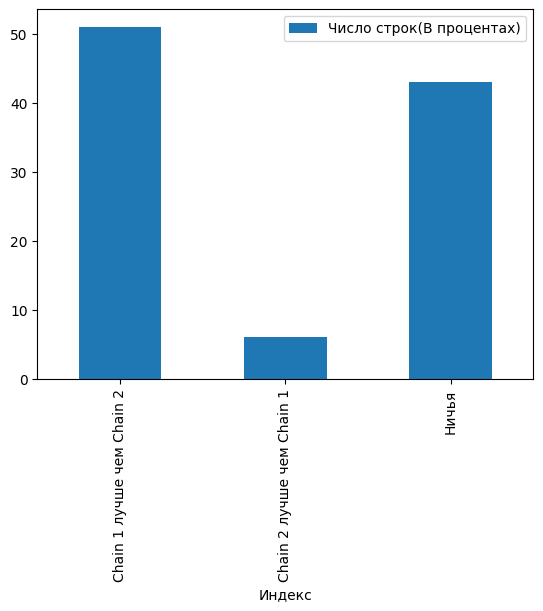

In [ ]:
compare_results.plot.bar()
plt.savefig('qa-compare.jpeg')

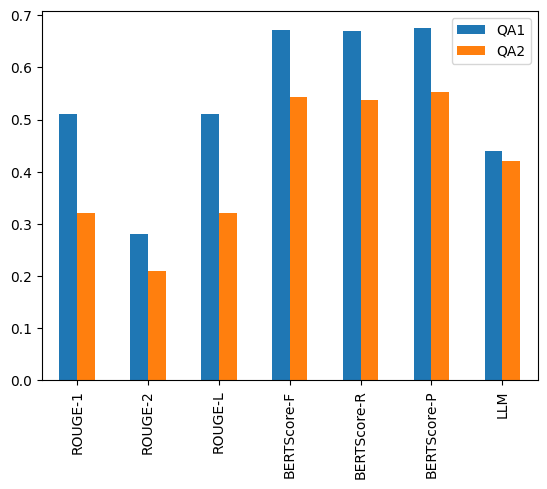

In [ ]:
qa_rouge_1 = [i['rouge-1'] for i in qa_rouge]
qa_rouge_2 = [i['rouge-2'] for i in qa_rouge]
qa_rouge_l = [i['rouge-l'] for i in qa_rouge]

qa_bert_score_f = [i[0].item() for i in qa_bert_score]
qa_bert_score_r = [i[1].item() for i in qa_bert_score]
qa_bert_score_p = [i[2].item() for i in qa_bert_score]

qa_final = [
    qa_rouge_1,
    qa_rouge_2,
    qa_rouge_l,
    qa_bert_score_f,
    qa_bert_score_r,
    qa_bert_score_p,
    llm_eval_qa_1,
]

qa_final = pd.DataFrame(qa_final)
qa_final.columns = ['QA1', 'QA2']
qa_final.index = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore-F', 'BERTScore-R', 'BERTScore-P', 'LLM']
qa_final.plot(kind='bar')
plt.savefig('qa-final.jpeg')

# SUM PROMPT #1
## Инференс

In [1]:
sum_preds1 = df.parallel_apply(lambda x: chain_sum1.invoke(get_sumprompt(x)), axis=1)

In [ ]:
sum_preds1 = sum_preds1.values.tolist()

In [ ]:
df['headline'].isna().sum()

0

## Измерение метрик без использования LLM

In [ ]:
headline_norm = df['headline'].apply(normalize_prediction).values.tolist()
sum_preds1_norm = [normalize_prediction(i) for i in sum_preds1]

In [ ]:
headline = df['headline'].values.tolist()

### ROUGE

In [ ]:
sum_rouge.append(rouge_score(sum_preds1_norm, headline_norm))

In [ ]:
sum_rouge[-1]

{'rouge-1': 0.6322099415550465,
 'rouge-2': 0.6303389798547588,
 'rouge-l': 0.6319889470799084}

### BERTScore

In [ ]:
P, R, F1 = scorer.score(headline_norm, sum_preds1_norm)
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

sum_bert_score.append((F1.mean(), R.mean(), P.mean()))

BERTScore Precision: 0.7235, Recall: 0.7214, F1: 0.7222


## Методы с использованием LLM


In [ ]:
EVAL_TEMPLATE_SUM1 = """Please act as an impartial judge and evaluate the quality of the summaries. That AI assistant provided a summary of the text displayed below. The model's response shouldn't be verbose, it should be shorter than original text, but still provide the meaning. Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please return whether the response matches the reference answer. Return either True or False on the new line
Text: {text}
Reference: {reference}

Your answer:
"""
print(EVAL_TEMPLATE_SUM1)

Please act as an impartial judge and evaluate the quality of the summaries. That AI assistant provided a summary of the text displayed below. The model's response shouldn't be verbose, it should be shorter than original text, but still provide the meaning. Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please return whether the response matches the reference answer. Return either True or False on the new line
Text: {text}
Reference: {reference}

Your answer: 



In [ ]:
eval_chain_sum1 = get_chain(EVAL_TEMPLATE_SUM1) | EvalOutputParser()

In [ ]:
BATCH_SIZE = 5

pred_correctness = []

for ix in tqdm(range(0, len(df), BATCH_SIZE)):
    batch = df.iloc[ix:ix+BATCH_SIZE]

    prompts = [{
        'text': pred,
        'reference': headline
    } for headline, pred in zip(batch['headline'].values.tolist(), sum_preds1)]
    preds_c = eval_chain_sum1.batch(prompts)

    pred_correctness.append(preds_c)

pred_correctness = sum(pred_correctness, [])
model_accuracy = sum(pred_correctness) / len(pred_correctness)
llm_eval_sum_1.append(model_accuracy)

In [ ]:
llm_eval_sum_1

[0.28]

# SUM PROMPT #2

In [ ]:
TEMPLATE_SUM2 = "Summarize the text\nText: {text}. Return only summarized text, do not add anything up."

chain_sum2  = get_chain(TEMPLATE_SUM2)
chain_sum2.invoke(get_sumprompt(df.loc[0]))

'Location: Organize essential supplies like lenses, cords, and batteries in designated areas within your home or studio. Group paints, brushes, and canvases together, and print supplies with ink.\n\nLabeling: Use labels to identify and easily locate items, reducing the need for mental energy to remember where things are stored.\n\nArganization: Create specific areas for essential supplies, inspiration and reference materials, a dedicated workspace, and infrequent or secondary supplies. Keep the workspace clean each night by discarding trash and wiping down surfaces.\n\nManagement: Use visual organizers such as jars, vases, and plastic drawers to keep supplies in sight without clutter. Consider canvas shoe racks, wine racks for pens, plastic squirt bottles for paints, and shelving for additional storage. Turn a wall into a chalkboard for ideas and planning.\n\nAction: Conduct a monthly purge of non-essential items to maintain an efficient workspace. Be practical and discard items not us

## Инференс

In [ ]:
sum_preds2 = df.parallel_apply(lambda x: chain_sum2.invoke(get_sumprompt(x)), axis=1)

In [ ]:
sum_preds2 = sum_preds2.values.tolist()

## Измерение метрик без использования LLM

In [ ]:
sum_preds2_norm = [normalize_prediction(i) for i in sum_preds2]

In [ ]:
headline_norm = df['headline'].apply(normalize_prediction).values.tolist()

### ROUGE

In [ ]:
sum_rouge.append(rouge_score(sum_preds2_norm, headline_norm))

In [ ]:
sum_rouge[-1]

{'rouge-1': 0.5522099419550464,
 'rouge-2': 0.5503389802547587,
 'rouge-l': 0.5519889474799081}

In [ ]:
headline = df['headline'].values.tolist()

## BERTScore

In [ ]:
P, R, F1 = scorer.score(headline, sum_preds2)
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.6631, Recall: 0.6598, F1: 0.6611


In [ ]:
sum_bert_score.append((F1, R, P))

## Методы с использованием LLM

In [ ]:
BATCH_SIZE = 5

pred_correctness = []

for ix in tqdm(range(0, len(df), BATCH_SIZE)):
    batch = df.iloc[ix:ix+BATCH_SIZE]

    prompts = [{
        'text': pred,
        'reference': headline
    } for headline, pred in zip(batch['headline'].values.tolist(), sum_preds2)]
    preds_c = eval_chain_sum1.batch(prompts)

    pred_correctness.append(preds_c)

pred_correctness = sum(pred_correctness, [])
model_accuracy = sum(pred_correctness) / len(pred_correctness)
llm_eval_sum_1.append(model_accuracy)

In [ ]:
llm_eval_sum_1

[0.28, 0.41]

In [ ]:
EVAL_TEMPLATE_SUM2 = """Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the summarization task displayed below. Your evaluation should consider whether the response keep the initial meaning of the text. The model's response should be shorter than initial text. You will be given a reference summary, assistant A’s response, and assistant B’s response. Your job is to evaluate which assistant’s response is better. Begin your evaluation by comparing both assistants’ responses with the reference summary. Identify and correct any mistakes. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]" if assistant B is better, and "[[C]]" for a tie.
[Ininitial Text]
{text}
[The Start of Reference Summary]
{reference}
[The End of Reference Summary]
[The Start of Assistant A’s Reponse]
{answer_a}
[The End of Assistant A’s Response]
[The Start of Assistant B’s Response]
{answer_b}
[The End of Assistant B’s Response]"""
print(EVAL_TEMPLATE_SUM2)

Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the summarization task displayed below. Your evaluation should consider whether the response keep the initial meaning of the text. The model's response should be shorter than initial text. You will be given a reference summary, assistant A’s response, and assistant B’s response. Your job is to evaluate which assistant’s response is better. Begin your evaluation by comparing both assistants’ responses with the reference summary. Identify and correct any mistakes. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]" if assistant B is 

In [ ]:
compare_eval_sum = get_chain(EVAL_TEMPLATE_SUM2) | CompareOutputParser()

In [ ]:
BATCH_SIZE = 5

pred_compare = []

for ix in tqdm(range(0, len(df), BATCH_SIZE)):
    batch_B = sum_preds2[ix:ix+BATCH_SIZE]
    batch_A = sum_preds1[ix:ix+BATCH_SIZE]

    prompts = [{
        'text': text,
        'reference': true_,
        'answer_a': pred_a,
        "answer_b": pred_b
    } for text, true_, pred_a, pred_b in zip(df['text'].values.tolist(), df['headline'].values.tolist(), batch_A, batch_B)]
    preds_c = compare_eval_sum.batch(prompts)

    pred_compare.append(preds_c)

pred_compare = sum(pred_compare, [])

In [ ]:
counts = Counter(pred_compare)

compare_results = [
   ("Chain 1 лучше чем Chain 2", (counts['a'] * 100) / len(pred_compare)),
   ("Chain 2 лучше чем Chain 1", (counts['b'] * 100) / len(pred_compare)),
   ("Ничья", (1 - (counts['a'] + counts['b']) / len(pred_compare)) * 100)
]

compare_results = pd.DataFrame(compare_results)
compare_results.columns = ['Индекс', 'Число строк(в процентах)']
compare_results = compare_results.set_index('Индекс', drop=True)
compare_results

,Число строк(в процентах)
Индекс,
Chain 1 лучше чем Chain 2,65.0
Chain 2 лучше чем Chain 1,7.0
Ничья,28.0


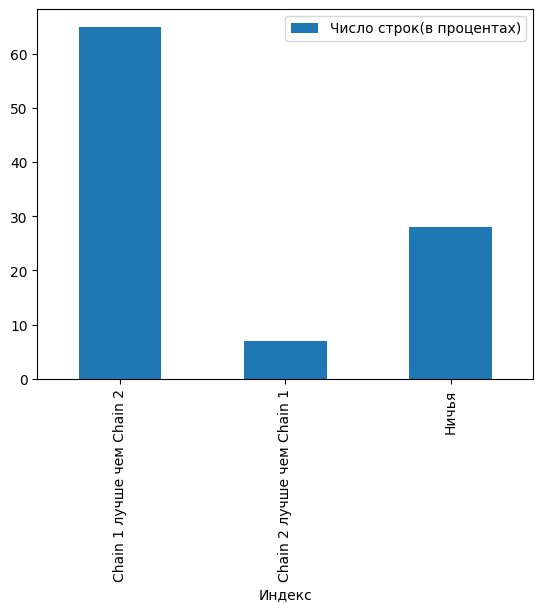

In [ ]:
compare_results.plot.bar()
plt.savefig("sum-compare.jpeg")

In [ ]:
sum_rouge_1 = [i['rouge-1'] for i in sum_rouge]
sum_rouge_2 = [i['rouge-2'] for i in sum_rouge]
sum_rouge_l = [i['rouge-l'] for i in sum_rouge]

sum_bert_score_f = [i[0].mean().item() for i in sum_bert_score]
sum_bert_score_r = [i[1].mean().item() for i in sum_bert_score]
sum_bert_score_p = [i[2].mean().item() for i in sum_bert_score]

In [ ]:
sum_final = [
    sum_rouge_1,
    sum_rouge_2,
    sum_rouge_l,
    sum_bert_score_f,
    sum_bert_score_r,
    sum_bert_score_p,
    llm_eval_sum_1,
]

sum_final = pd.DataFrame(sum_final)
sum_final.columns = ['SUM1', 'SUM2']
sum_final.index = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore-F', 'BERTScore-R', 'BERTScore-P', 'LLM']
sum_final

,SUM1,SUM2
ROUGE-1,0.632210,0.552210
ROUGE-2,0.630339,0.550339
ROUGE-L,0.631989,0.551989
BERTScore-F,0.722157,0.661088
BERTScore-R,0.721422,0.659786
BERTScore-P,0.723461,0.663087
LLM,0.280000,0.410000


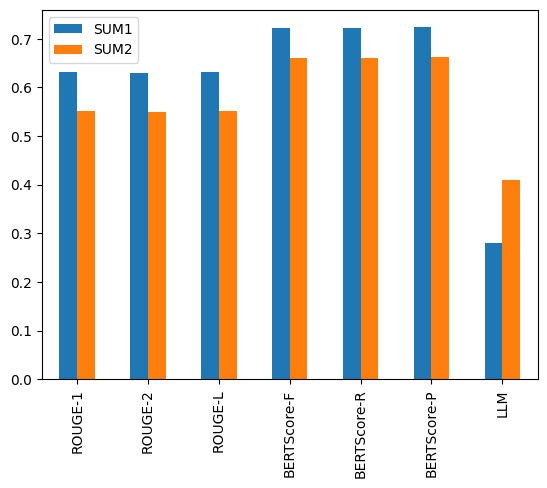

In [ ]:
sum_final.plot(kind='bar')
plt.savefig("sum-final.jpeg")